In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
plt.rcParams['font.size'] = 16

In [2]:
path='/kaggle/input/pizza-not-pizza'
dir='/kaggle/input/pizza-not-pizza/pizza_not_pizza'

In [4]:
img_size=224
batch_size=32

datagen=ImageDataGenerator(rescale=1/255.,
                            horizontal_flip=True,
                            vertical_flip=True,
                            zoom_range=0.025,
                            rotation_range=20,
                           validation_split=0.20
                          )

train_gen=datagen.flow_from_directory(dir,
                                      batch_size=batch_size,
                                      target_size=(img_size,img_size),
                                      shuffle=True,
                                      subset='training',
                                  class_mode='binary'
)


val_gen=datagen.flow_from_directory(dir,
                                      batch_size=batch_size,
                                      target_size=(img_size,img_size),
                                      shuffle=False,
                                      subset='validation',
                                      class_mode='binary',
)

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [6]:
train_gen.class_indices

{'not_pizza': 0, 'pizza': 1}

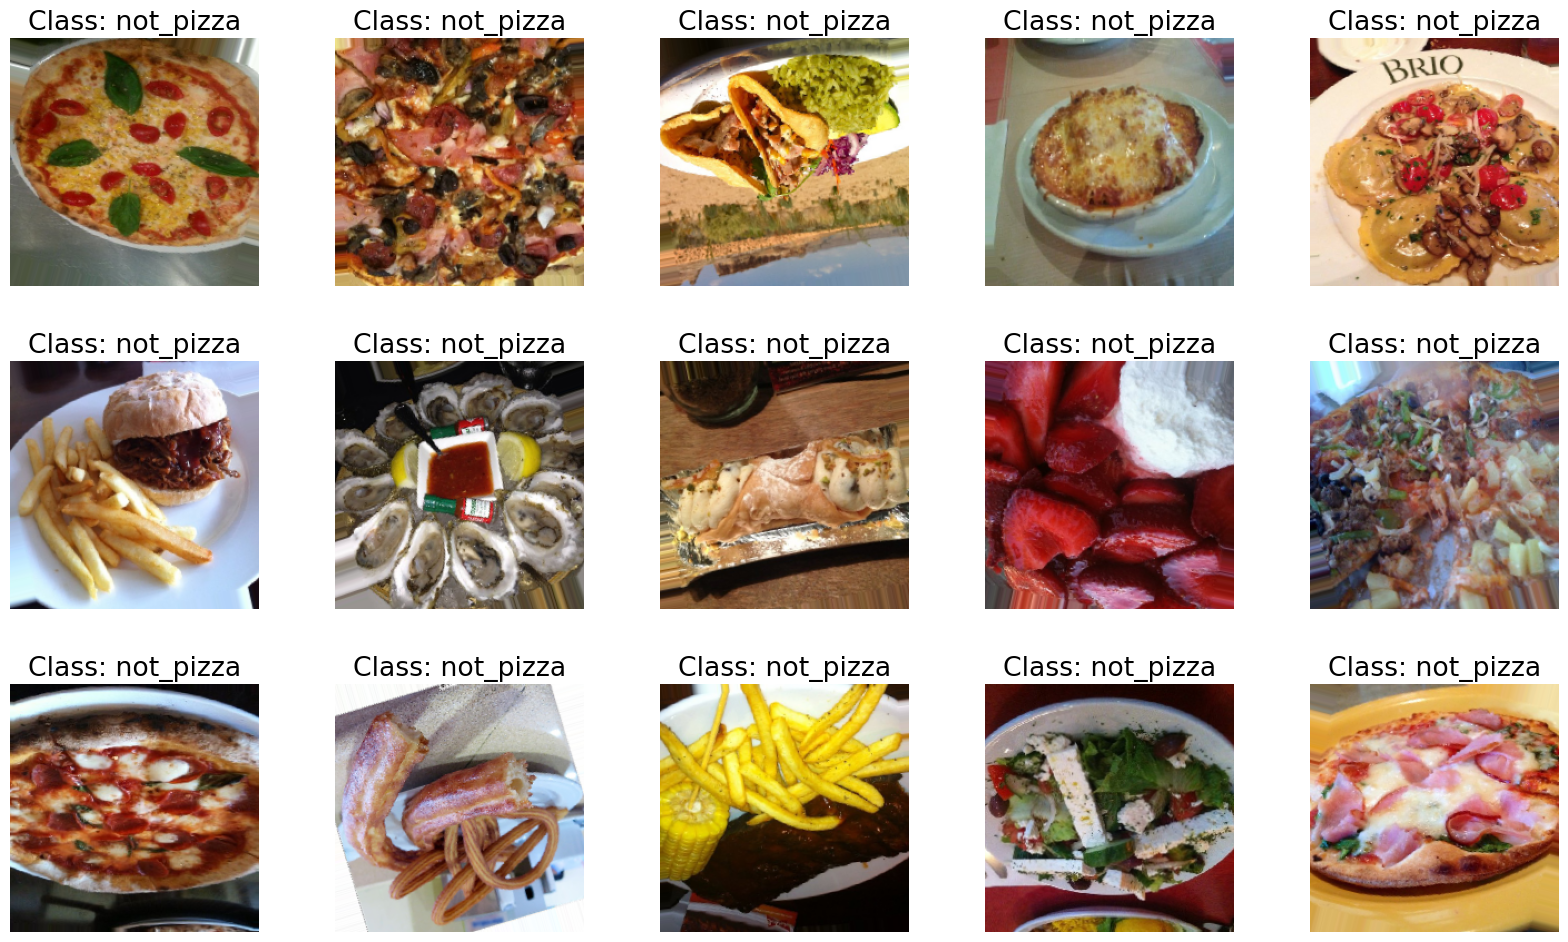

In [5]:
labels = [k for k in train_gen.class_indices]
sample_generate = train_gen.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [7]:
base_model=MobileNet(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
)

17225924/17225924 [==============================] - 0s 0us/step


In [8]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [10]:
index = None
for idx, layer in enumerate(base_model.layers):
    if layer.name == 'conv_dw_4_relu (ReLU)':
        index = idx
        break                                      
 

In [23]:
layer_names = [layer.name for layer in base_model.layers]
layer_idx = layer_names.index('conv_pw_4_relu')

In [24]:
layer_idx

29

In [25]:
for layer in base_model.layers[:-29]:
    layer.trainable=False

In [32]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [33]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [34]:
try:
    history = model.fit(train_gen,
                        epochs=5,
                        validation_data=val_gen,
                        callbacks=[checkpoint,earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8761
Epoch 1: val_loss improved from inf to 0.31953, saving model to model.h5
50/50 [==============================] - 95s 2s/step - loss: 0.4419 - accuracy: 0.8761 - val_loss: 0.3195 - val_accuracy: 0.8597
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.9117
Epoch 2: val_loss improved from 0.31953 to 0.25507, saving model to model.h5
50/50 [==============================] - 89s 2s/step - loss: 0.2638 - accuracy: 0.9117 - val_loss: 0.2551 - val_accuracy: 0.8929
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9161
Epoch 3: val_loss improved from 0.25507 to 0.21216, saving model to model.h5
50/50 [==============================] - 90s 2s/step - loss: 0.2052 - accuracy: 0.9161 - val_loss: 0.2122 - val_accuracy: 0.9133
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9244
Epoch 4: val_l

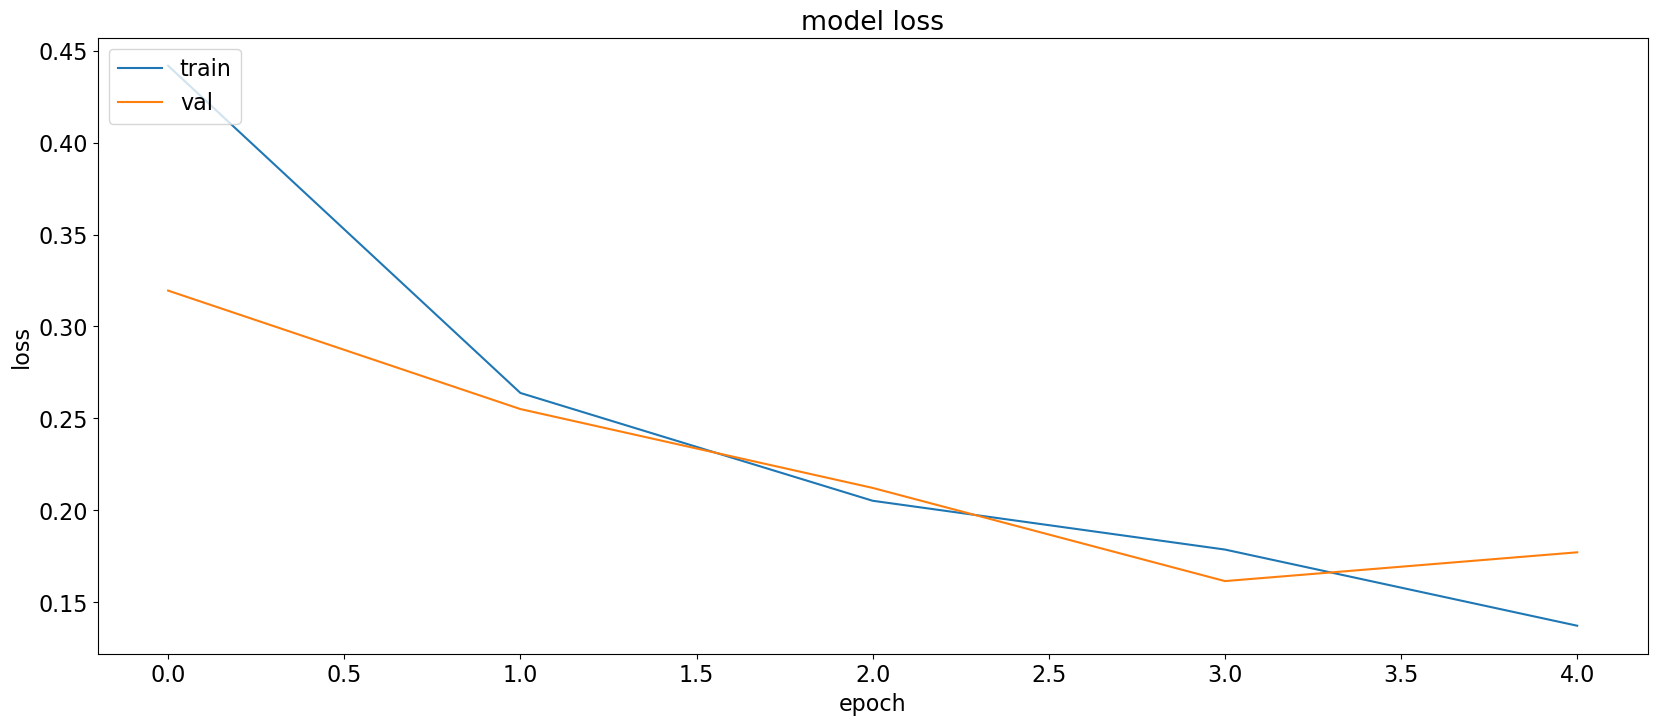

In [35]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


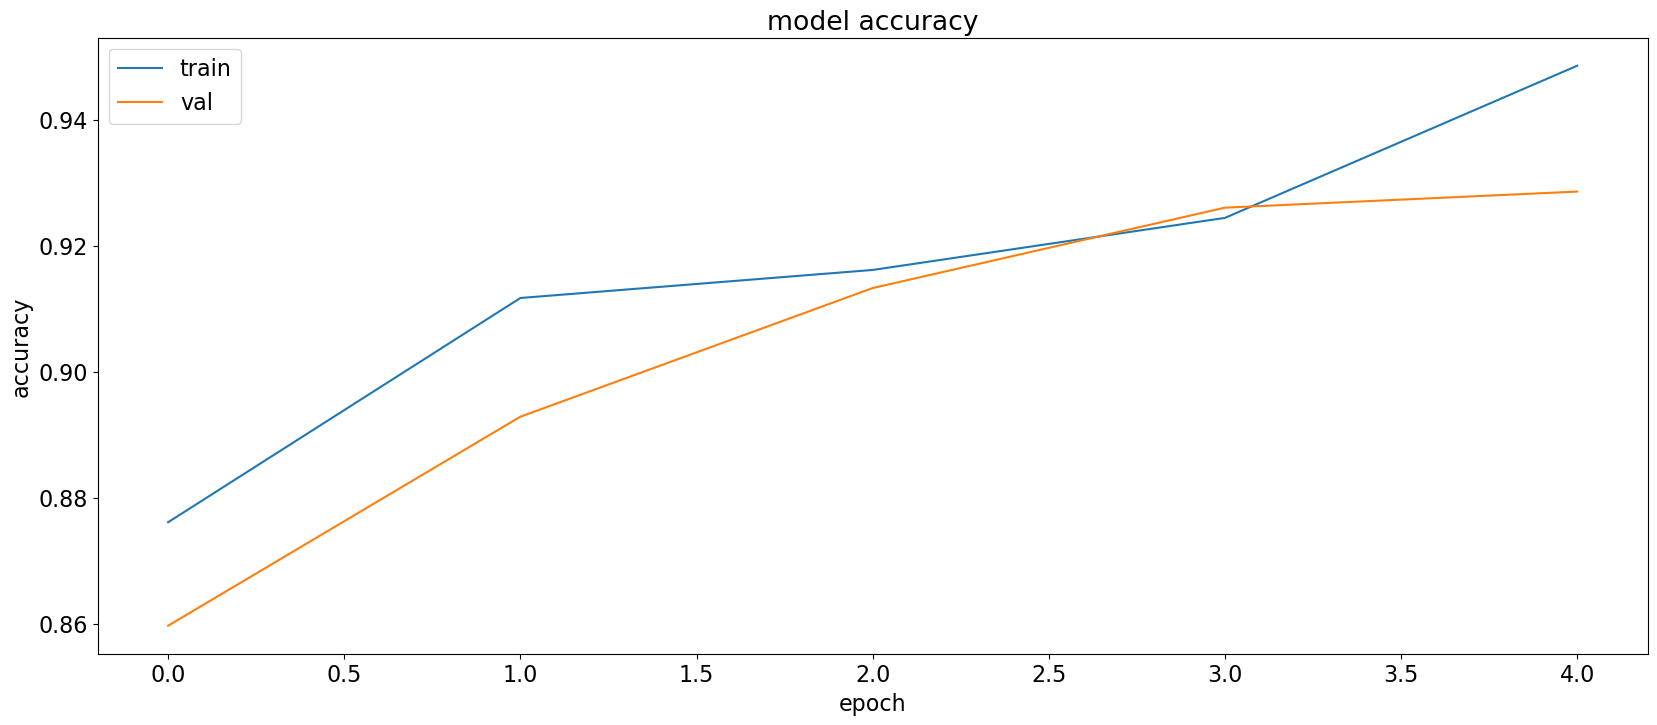

In [36]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
best_model=tf.keras.models.load_model('model.h5')

In [70]:
y_test = val_gen.classes
y_pred_val = best_model.predict(val_gen)
y_pred_val2 = y_pred_val.copy()

# y_pred_val_argmax = np.argmax(y_pred_val,axis=1)
# y_pred_test = best_model.predict(val_gen,axis=1)
# y_pred_test = np.argmax(y_pred_test,axis=1)

13/13 [==============================] - 13s 974ms/step


In [73]:
y_pred_val[y_pred_val2>=0.5]=1
y_pred_val[y_pred_val2<0.5]=0

In [77]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,roc_auc_score

print(classification_report(y_test,y_pred_val,target_names = labels))

              precision    recall  f1-score   support

   not_pizza       0.97      0.87      0.92       196
       pizza       0.88      0.97      0.92       196

    accuracy                           0.92       392
   macro avg       0.92      0.92      0.92       392
weighted avg       0.92      0.92      0.92       392



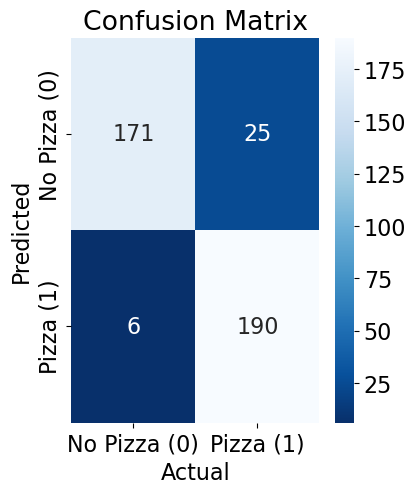

In [94]:
import seaborn as sns

plt.figure(figsize=(4,5))
sns.heatmap(confusion_matrix(y_test,y_pred_val),annot=True,cmap='Blues_r',fmt='.3g',
            xticklabels=['No Pizza (0)','Pizza (1)'], yticklabels=['No Pizza (0)','Pizza (1)'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

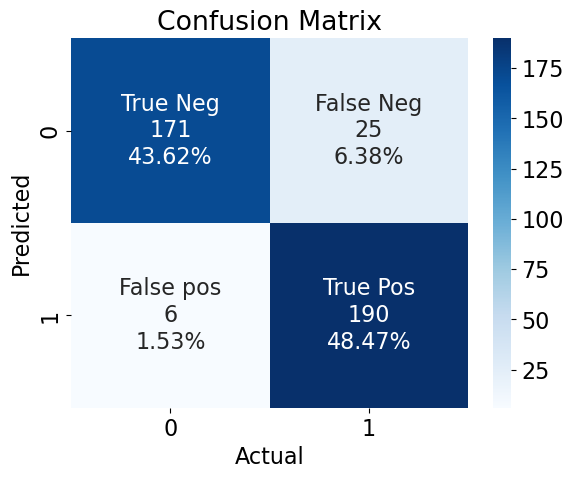

In [103]:
group_names = ['True Neg','False Neg','False pos','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix(y_test,y_pred_val) .flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix(y_test,y_pred_val).flatten()/np.sum(confusion_matrix(y_test,y_pred_val))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_val), annot=labels, fmt='', cmap='Blues')

plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title("Confusion Matrix")
plt.show()

false positive (type-1 error)  meaning it is false but model is predicting it as true

false negative(type-2 error) meaning it is true but model is predicting it as false

which is more dangerous depends on the context. so here we dont know the context so we cant decide on a threshold.

Depending on the context we will deicde if we want to decrease or increase the threshold value which will affect 

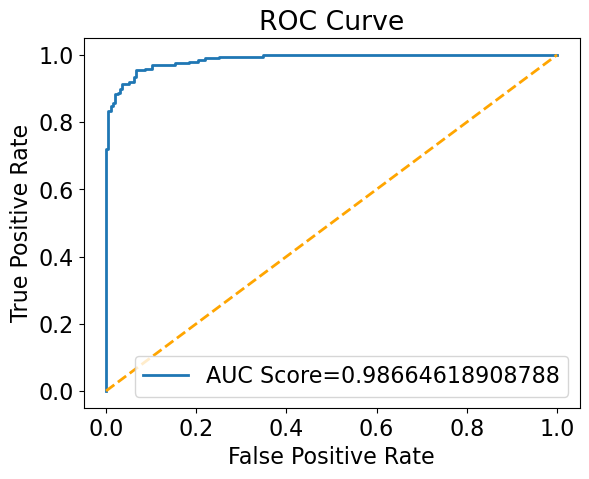

In [68]:
fpr,tpr,_=roc_curve(y_test,y_pred_val)
auc=roc_auc_score(y_test,y_pred_val)
plt.plot(fpr,tpr,label="AUC Score="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [63]:
np.argmax(tpr-fpr)

22

In [64]:
_[22]

0.714994